In [1]:
import pandas as pd
import spacy
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix

# loading main df and list of curated reference sentences for each label
df = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "dicho", index_col = 0)
c_good_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_value_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_bad_value_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_value_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_good_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_efficacy_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_bad_efficacy_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_efficacy_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_good_comm_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_good_comm_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_bad_comm_curated = pd.read_excel('../data/avis/general_df_clean_sent_15k_manual_code.xlsx', sheet_name = "c_bad_comm_curated", index_col=0, header=0).dropna(subset = "text_avis")
c_bad_value_curated.head()

# importing spacy model
nlp = spacy.load("fr_core_news_lg")
df.head(2)

,n_avis,date_avis,total_text,codes agrégés,c_good_value,c_bad_value,c_good_efficacy,c_bad_efficacy,c_good_comm,c_bad_comm
etoiles,,,,,,,,,,
3,3,2022-07-26 10:10:19,Pour l'instant toujours en attente. Pour l'ins...,bad:inefficace,0,0,0,1,0,0
3,1,2022-04-11 14:14:30,intérêts trop élevés. na,none,0,0,0,0,0,0


In [4]:
# all reviews text
list_exemples_tout = df.total_text

#bags with regeference text for each label
bag_good_value = nlp(" ".join([message for message in c_good_value_curated.text_avis]))
bag_bad_value = nlp(" ".join([message for message in c_bad_value_curated.text_avis]))
bag_good_comm = nlp(" ".join([message for message in c_good_comm_curated.text_avis]))
bag_bad_comm = nlp(" ".join([message for message in c_bad_comm_curated.text_avis]))
bag_good_efficacy = nlp(" ".join([message for message in c_good_efficacy_curated.text_avis]))
bag_bad_efficacy = nlp(" ".join([message for message in c_bad_efficacy_curated.text_avis]))

import numpy as np
test_thresh = np.arange(0.59,1.01, 0.01)


In [67]:
# fonctions et liste de seuils de similarité à tester



# stopword
def stop_word_text_list(text_list):
    liste_filtrée =[]
    round_count = 1
    for review in text_list:
        if round_count % 100 == 0:
            print(f"{round_count} reviews passed of {len(text_list)} - {round(round_count/len(text_list)*100,2)}% done")            
        filtre = []
        texte = nlp(review)
        liste_texte = list(texte)
        for word in liste_texte:
            if str(word) not in stop_words:
                filtre.append(str(word))
        filt_review = (" ".join(filtre))
        liste_filtrée.append(filt_review)
        round_count = round_count + 1
    return(liste_filtrée)

def allocate_lab(sim_score, y_pred, sim_thresh):
    if max(sim_score) > sim_thresh:
        y_pred.append(1)
    else:
        y_pred.append(0)

def similarity_report(y,y_pred):
    report =classification_report(y, y_pred, output_dict=True, zero_division=0)  
    macro_f1 = round(report['macro avg']['f1-score'],2)
    return(macro_f1)

def wrap(f1_scores,test_name,code_of_interest):
    best_score = round(max(f1_scores),2)
    best_thresh = round(test_thresh[f1_scores.index(best_score)],2)
    print(f"for {code_of_interest} best score: {best_score} using similarity thresh of {best_thresh}")
    temp_report = pd.DataFrame({"label":[code_of_interest],
                                    "test": [test_name],
                                    "word mode": [word_mode],
                                    "best train f1 score": [best_score],
                                    "threshold used": [best_thresh]})
    temp_report.to_csv(f"../reports/similarity/raw/{test_name}_{code_of_interest}_{word_mode}.csv")

def wrap_test(test_name,code_of_interest,thresh, macrof1):
    temp_report = pd.DataFrame({"label":[code_of_interest],
                                    "test": [test_name],
                                    "word mode": [word_mode],
                                    "test f1 score": [macrof1],
                                    "threshold used": [thresh]})
    temp_report.to_csv(f"../reports/similarity/raw/{test_name}_{code_of_interest}_{word_mode}.csv")

def compile_segundo(code_of_interest):
    # compiling grid results
    from os import listdir

    bench_list = listdir("../reports/similarity")
    bench_list.remove(".DS_Store")
    bench_list = [path for path in bench_list if code_of_interest in path]
    bench_list
    benchmark = pd.DataFrame()
    for file in bench_list:
        df = pd.read_csv(f'../reports/similarity/{file}', index_col=0)
        benchmark = pd.concat([benchmark, df])
    benchmark = benchmark.sort_values("best train accuracy score", ascending = False)
    benchmark
# functions to check best granularity and similarity threshold

def full_review_vs_whole_ref_bag(bag_of_ref,y,code_of_interest,test_name = "full_review_vs_whole_ref_bag"):
    print("passing ",test_name)
    f1_scores = []
    for thresh in test_thresh:
        y_pred = []
        for message in list_exemples_tout:
            sim_score = []
            message = nlp(message)
            sim_score.append(round(bag_of_ref.similarity(message),2))
            allocate_lab(sim_score,y_pred,thresh)
        macro_f1 = similarity_report(y,y_pred)
        f1_scores.append(macro_f1)
    #print(f"with threshold {round(thresh,2)}. {round((max(test_thresh)-thresh)*100)} to test until {round(max(test_thresh),2)} using {len(list_exemples_tout)} reviews")
    wrap(f1_scores,test_name,code_of_interest)
    return(f1_scores)

def review_sentence_vs_whole_ref_bag(bag_of_ref,y,code_of_interest,test_name = "review_sentence_vs_whole_ref_bag"):
    print("passing ",test_name)
    f1_scores = []
    for thresh in test_thresh:
        y_pred = []
        for message in list_exemples_tout:
            sim_score= []
            message = nlp(message)
            sentences = message.sents
            for sentence in sentences:
                if sentence.has_vector:
                    temp_sim_score = round(bag_of_ref.similarity(sentence),2)
                    sim_score.append(temp_sim_score)
            allocate_lab(sim_score,y_pred,thresh)
        macro_f1 = similarity_report(y,y_pred)
        f1_scores.append(macro_f1)
        #print(f"with threshold {round(thresh,2)}. {round((max(test_thresh)-thresh)*100)} to test until {round(max(test_thresh),2)} using {len(list_exemples_tout)} reviews")
    wrap(f1_scores,test_name,code_of_interest)
    return(f1_scores)

def review_sentence_vs_ref_étalon(étalon,y,code_of_interest):
    test_name = "review_sentence_vs_ref_étalon"
    print("passing ",test_name)
    f1_scores = []
    for thresh in test_thresh:
        y_pred = []
        for message in list_exemples_tout:
            sim_score= []
            message = nlp(message)
            sentences = message.sents
            for sentence in sentences:
                if sentence.has_vector:
                    temp_sim_score = round(etalon.similarity(sentence),2)
                    sim_score.append(temp_sim_score)
            allocate_lab(sim_score,y_pred,thresh)
        macro_f1 = similarity_report(y,y_pred)
        f1_scores.append(macro_f1)
        #print(f"with threshold {round(thresh,2)}. {round((max(test_thresh)-thresh)*100)} to test until {round(max(test_thresh),2)} using {len(list_exemples_tout)} reviews")
    wrap(f1_scores,test_name,code_of_interest)
    return(f1_scores)

def full_review_vs_étalon(etalon, y,code_of_interest):
    test_name = "full_review_vs_étalon"
    print("passing ",test_name)
    f1_scores = []
    for thresh in test_thresh:
        y_pred = []
        for message in list_exemples_tout:
            sim_score = []
            message = nlp(message)
            sim_score.append(round(etalon.similarity(message),2))
            allocate_lab(sim_score,y_pred,thresh)
        macro_f1 = similarity_report(y,y_pred)
        f1_scores.append(macro_f1)
        #print(f"with threshold {round(thresh,2)}. {round((max(test_thresh)-thresh)*100)} to test until {round(max(test_thresh),2)} using {len(list_exemples_tout)} reviews")
    wrap(f1_scores,test_name,code_of_interest)
    return(f1_scores)

def review_sentence_vs_reference_sentence(bag, y,code_of_interest):
    test_name = "review_sentence_vs_reference_sentence"
    print("passing ",test_name)
    f1_scores = []
    for thresh in test_thresh:
        y_pred = []
        for message in list_exemples_tout:
            sim_score= []
            message = nlp(message)
            sentences = message.sents
            sentences_exemples = bag.sents
            for sentence in sentences:
                if sentence.has_vector:
                    for sentence_exemple in sentences_exemples:
                        if sentence_exemple.has_vector:
                            temp_sim_score = round(sentence_exemple.similarity(sentence),2)
                            sim_score.append(temp_sim_score)
            allocate_lab(sim_score,y_pred,thresh)
        macro_f1 = similarity_report(y,y_pred)
        f1_scores.append(macro_f1)
        #print(f"with threshold {round(thresh,2)}. {round((max(test_thresh)-thresh)*100)} to test until {round(max(test_thresh),2)} using {len(list_exemples_tout)} reviews")
    wrap(f1_scores,test_name,code_of_interest)
    return(f1_scores)

# Main grid — One function to call them all
def grid_thresh_granularity(etalon,bag,y,code_of_interest):
    
    # [full review] vs [bag of exemples]
    full_review_vs_whole_ref_bag(bag,y,code_of_interest)

    # [reviews sentences] vs [bag of exemples]
    review_sentence_vs_whole_ref_bag(bag,y,code_of_interest)

    #[reviews sentences] vs [étalon]
    review_sentence_vs_ref_étalon(etalon, y,code_of_interest)

    # [reviews sentences] vs [étalon]
    full_review_vs_étalon(etalon, y,code_of_interest)

    # [reviews sentences] vs [bag of exemples sentences] 
    review_sentence_vs_reference_sentence(bag,y,code_of_interest)

    # compiling and sorting the grid results for granularity and similarity threshold
    compile_segundo(code_of_interest)


In [8]:
# removing stopwords

df['total_text'] = df['total_text'].fillna('').astype(str)
df['total_text'] = [message.lower() for message in df['total_text']]
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

df["text_stop"] = stop_word_text_list(df['total_text'])

100 reviews passed of 115 - 86.96% done


etoiles
3    instant attente . instant attente , jours manq...
3                               intérêts trop élevés .
2    meilleurs , . dernières fois dû faire appel fo...
1    aidez . aidez , faites inverse , déteste , com...
1    voyage étranger conseillé … . voyage étranger ...
                           ...                        
4    bonjour , . bonjour , cofidis su faire preuve ...
3    mieux faire . mieux faire ! bien mieux pauses ...
4    réactif rapide . réactif rapide , réponse appr...
1    organisme bancaire prélève … . organisme banca...
1    recommande ! . bonjour , effectué paiement 3 f...
Name: text_stop, Length: 115, dtype: object

best score: 0.63 using similarity thresh of 0.7
best score: 0.6 using similarity thresh of 0.76


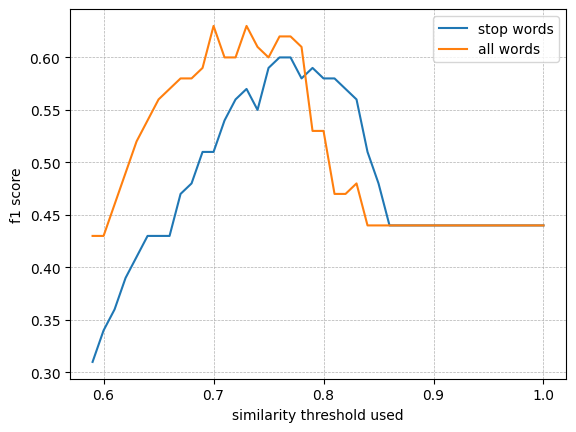

In [19]:
code_of_interest ="c_good_efficacy"
word_mode = "all_words"
baseline_all_words = full_review_vs_whole_ref_bag(bag_good_efficacy,df[code_of_interest],code_of_interest,"baseline_all_words")

word_mode = "stop"
bag_good_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_efficacy_curated.text_avis)]))
baseline_stop_words = full_review_vs_whole_ref_bag(bag_good_efficacy_stop,df[code_of_interest],code_of_interest,"baseline_stop_words")
import matplotlib.pyplot as plt

plt.plot(test_thresh,baseline_stop_words, label ="stop words")
plt.plot(test_thresh, baseline_all_words, label = "all words")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("similarity threshold used")
plt.ylabel("f1 score")
plt.legend()
plt.show();

We will test both stop words and full words in similarity matching

In [20]:
# making stop word versions of our reference documents
bag_good_comm_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_comm_curated.text_avis)]))
bag_bad_comm_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_comm_curated.text_avis)]))
bag_good_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_value_curated.text_avis)]))
bag_bad_value_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_value_curated.text_avis)]))
bag_good_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_good_efficacy_curated.text_avis)]))
bag_bad_efficacy_stop = nlp(" ".join([message for message in stop_word_text_list(c_bad_efficacy_curated.text_avis)]))

Running similarity grids to test best granularity (sentence vs whole text; ref as whole ref, as sentence or replaced by keywords) for STOP words

In [29]:
list_exemples_tout = df['text_stop']
word_mode = "stop"

# good efficacy
code_of_interest ="c_good_efficacy"
etalon = nlp("super efficace rapide") 
grid_thresh_granularity(etalon,bag_good_efficacy_stop,df[code_of_interest],code_of_interest)

# bad efficacy
code_of_interest ="c_bad_efficacy"
etalon = nlp("nul inefficace lent") 
grid_thresh_granularity(etalon,bag_bad_efficacy_stop,df[code_of_interest],code_of_interest)

# good comm
code_of_interest ="c_good_comm"
etalon = nlp("attentif disponible poli") 
grid_thresh_granularity(etalon,bag_good_comm_stop,df[code_of_interest],code_of_interest)

# bad comm
code_of_interest ="c_bad_comm"
etalon = nlp("mépris silence malpoli") 
grid_thresh_granularity(etalon,bag_bad_comm_stop,df[code_of_interest],code_of_interest)

# good value stop
code_of_interest ="c_good_value"
etalon = nlp("abordable accordé") 
grid_thresh_granularity(etalon,bag_good_value_stop,df[code_of_interest],code_of_interest)

# bad value stop
code_of_interest ="c_bad_value"
etalon = nlp("cher refusé") 
grid_thresh_granularity(etalon,bag_bad_value_stop,df[code_of_interest],code_of_interest)

passing  full_review_vs_whole_ref_bag
for c_good_efficacy best score: 0.6 using similarity thresh of 0.76
passing  review_sentence_vs_whole_ref_bag
for c_good_efficacy best score: 0.55 using similarity thresh of 0.77
passing  review_sentence_vs_ref_étalon
for c_good_efficacy best score: 0.64 using similarity thresh of 0.59
passing  full_review_vs_étalon
for c_good_efficacy best score: 0.64 using similarity thresh of 0.59
passing  review_sentence_vs_reference_sentence
for c_good_efficacy best score: 0.68 using similarity thresh of 0.82
passing  full_review_vs_whole_ref_bag
for c_bad_efficacy best score: 0.73 using similarity thresh of 0.77
passing  review_sentence_vs_whole_ref_bag
for c_bad_efficacy best score: 0.72 using similarity thresh of 0.72
passing  review_sentence_vs_ref_étalon
for c_bad_efficacy best score: 0.39 using similarity thresh of 0.59
passing  full_review_vs_étalon
for c_bad_efficacy best score: 0.39 using similarity thresh of 0.59
passing  review_sentence_vs_reference

In [ ]:
list_exemples_tout = df['total_text']
word_mode ="allwords"

# good efficacy
code_of_interest ="c_good_efficacy"
etalon = nlp("super efficace rapide") 
grid_thresh_granularity(etalon,bag_good_efficacy,df[code_of_interest],code_of_interest)

# bad efficacy
code_of_interest ="c_bad_efficacy"
etalon = nlp("nul inefficace lent") 
grid_thresh_granularity(etalon,bag_bad_efficacy,df[code_of_interest],code_of_interest)

# good comm
code_of_interest ="c_good_comm"
etalon = nlp("attentif disponible poli") 
grid_thresh_granularity(etalon,bag_good_comm,df[code_of_interest],code_of_interest)

# bad comm
code_of_interest ="c_bad_comm"
etalon = nlp("mépris silence malpoli") 
grid_thresh_granularity(etalon,bag_bad_comm,df[code_of_interest],code_of_interest)

# good value stop
code_of_interest ="c_good_value"
etalon = nlp("abordable accordé") 
grid_thresh_granularity(etalon,bag_good_value,df[code_of_interest],code_of_interest)

# bad value stop
code_of_interest ="c_bad_value"
etalon = nlp("cher refusé") 
grid_thresh_granularity(etalon,bag_bad_value,df[code_of_interest],code_of_interest)

Let's make a heatmap to see the different methods train f1 scores

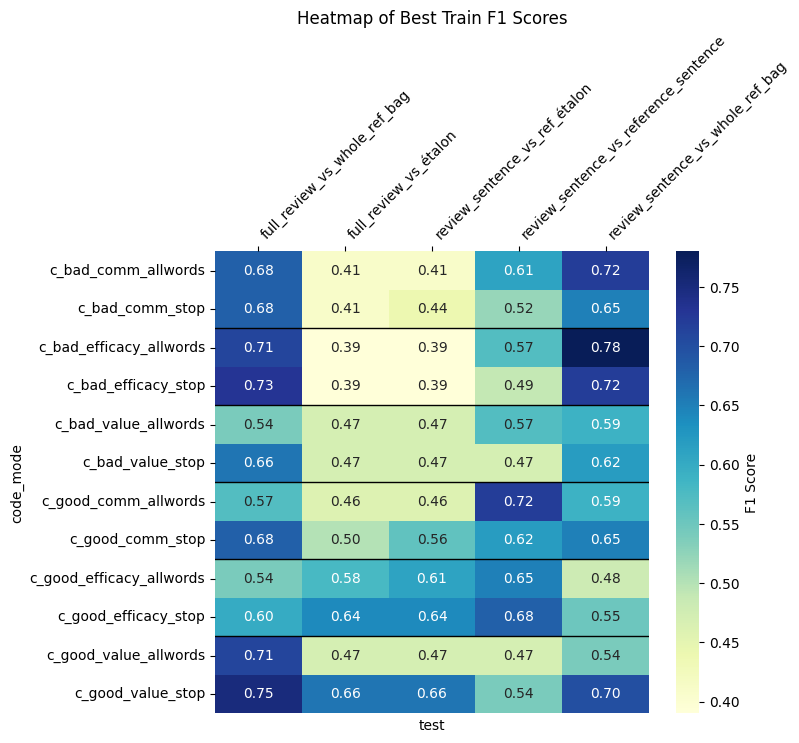

In [84]:
from os import listdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# compile the grid results
bench_list = listdir("../reports/similarity/raw")
try: 
    bench_list.remove(".DS_Store")
except:
    print()
bench_list = [path for path in bench_list if "baseline" not in path]

benchmark = pd.DataFrame()
for file in bench_list:
    df = pd.read_csv(f'../reports/similarity/raw/{file}', index_col=0)
    benchmark = pd.concat([benchmark, df])
benchmark = benchmark.sort_values("best train accuracy score", ascending = False)
benchmark['code_mode'] = benchmark.label + "_" + benchmark['word mode']

# pivot table heatmap
pivot = benchmark.pivot_table(index='code_mode', columns='test', values='best train accuracy score')
plt.figure(figsize=(7, 6))  
heatmap = sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0, linecolor='grey')

# horizontal lines 
for i in range(2, len(pivot.index), 2):
    plt.axhline(i, color='black', linestyle='-', linewidth=1)

# Label the color bar
color_bar = heatmap.collections[0].colorbar
color_bar.set_label('F1 Score')

plt.title('Heatmap of Best Train F1 Scores')
heatmap.xaxis.tick_top() 
plt.xticks(rotation=45, ha='left')  # Align the x-ticks properly
plt.show()

The heatmap shows that using **keywords** drives _worse results_ than example based solutions, all the more for labels that have many exemples (bad communicatin, bad efficacy). 

Results are more _nuanced_ regarding the use of **all words** or **removing stopwords** and on using the **whole document** (review or reference exemples) or **sentence** based similarity scoring. 

**Good F1 Scores** were obtained using:
* Full review vs full reference document using stopwords (for c_good_value_stop **.75**)
* Review sentence vs reference sentences with all words (c_good_comm_allwords, **.72**),
* Review sentence and whole reference document using both
    * Stopwords (c_bad_efficacy_stop **.72**) 
    * All words (c_bad_efficacy_allwords **.78**).

Some labels draw less optimal F1-scores: c_bad value (max .66),c_good_efficacy (max .68)

Overall **results could be improved** by:
* **Labelling more messages** to make more robust training dataset. 
    * If the selection of the labels reference sentences  becomes tedious with larger sets, it could be automated by running **TF/IDF** between the reference documents and only keeping words which are prevalent and relevant to each. For this smaller subset I prefered to rely on my own judgment and experience in qualitative research to select best sentences.
* Using a **stronger model like Camembert** (or BERT for English) could yield much finer semantic similarity estimates. Here we used fr_core_news_lg which has less parameters but can be conveniently used within spaCy.

These results are based on the training dataset, we will run the best parameters on the **test** dataset to see how our scores handle unseen data.

To do that, we will extract the **optimal parameters** (document granularity, all word/stopwords, optimal threshold) to run the labelling on the test and then on the larger dataset in the best available conditions.

In [49]:
best_params = pd.DataFrame()
def compile_best_params(label,best_params):
    code_df = benchmark[benchmark['label'] == label]
    best_threshold_index = code_df['best train accuracy score'].idxmax()
    best_threshold = code_df['threshold used'].iloc[best_threshold_index]
    best_method = code_df['test'].iloc[best_threshold_index]
    best_accuracy = code_df['best train accuracy score'].iloc[best_threshold_index]
    best_mode = code_df['word mode'].iloc[best_threshold_index]

    temp_df = pd.DataFrame({
        "label": [label],
        "Accuracy": [best_accuracy],
        "best_threshold": [best_threshold],
        "Method": [best_method],
        "Word mode": [best_mode]
    })
    best_params = pd.concat([best_params, temp_df], ignore_index= True)
    return best_params
label_names = set(benchmark["label"])
for label in label_names:
    best_params = compile_best_params(label,best_params)
best_params

,label,Accuracy,best_threshold,Method,Word mode
0,c_bad_value,0.66,0.85,full_review_vs_whole_ref_bag,stop
1,c_bad_efficacy,0.78,0.84,review_sentence_vs_whole_ref_bag,allwords
2,c_good_comm,0.72,0.82,review_sentence_vs_reference_sentence,allwords
3,c_good_efficacy,0.68,0.82,review_sentence_vs_reference_sentence,stop
4,c_bad_comm,0.72,0.83,review_sentence_vs_whole_ref_bag,allwords
5,c_good_value,0.75,0.82,full_review_vs_whole_ref_bag,stop


In [50]:
# check requiered methods
set(best_params.Method)

{'full_review_vs_whole_ref_bag',
 'review_sentence_vs_reference_sentence',
 'review_sentence_vs_whole_ref_bag'}

In [70]:
def final_full_review_vs_whole_ref_bag(bag_of_ref,y,code_of_interest,thresh):
    test_name = "test_review_vs_whole_ref_bag"
    print("passing ",test_name)
    y_pred = []
    for message in list_exemples_tout:
        sim_score = []
        message = nlp(message)
        sim_score.append(round(bag_of_ref.similarity(message),2))
        allocate_lab(sim_score,y_pred,thresh)
    macro_f1 = similarity_report(y,y_pred)
    wrap_test(test_name,code_of_interest,thresh,macro_f1)
    return(macro_f1)

def test_review_sentence_vs_reference_sentence(bag_of_ref,y,code_of_interest,thresh):
    test_name = "test review_sentence_vs_reference_sentence"
    print("passing ",test_name)
    y_pred = []
    for message in list_exemples_tout:
        sim_score= []
        message = nlp(message)
        sentences = message.sents
        sentences_exemples = bag.sents
        for sentence in sentences:
            if sentence.has_vector:
                for sentence_exemple in sentences_exemples:
                    if sentence_exemple.has_vector:
                        temp_sim_score = round(sentence_exemple.similarity(sentence),2)
                        sim_score.append(temp_sim_score)
        allocate_lab(sim_score,y_pred,thresh)
    macro_f1 = similarity_report(y,y_pred)
    wrap(test_name,code_of_interest,thresh,macro_f1)
    return(macro_f1)

In [69]:
test = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "test", index_col= 0)
y = test.var_efficacité_bad
list_exemples_tout = test.text_avis.fillna("na")

final_full_review_vs_whole_ref_bag(bag_bad_efficacy,y,"c_bad_efficacy", 0.85)

passing  test_review_vs_whole_ref_bag


0.76

In [71]:
test = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "test", index_col= 0)
y = test.var_efficacité_bad
list_exemples_tout = test.text_avis.fillna("na")

final_full_review_vs_whole_ref_bag(bag_bad_efficacy,y,"c_bad_efficacy", 0.85)

passing  test_review_vs_whole_ref_bag


0.76

Running classification on test set using the best granularity and threshold

In [ ]:
#  TEST [sentences of messages] vs [sentences of bag of exemples] -> 0.72 using similarity thresh of 0.83
test = pd.read_excel("../data/avis/general_df_clean_sent_15k_manual_code.xlsx",
                                   sheet_name = "test", index_col= 0)
test_text = test.text_avis
y = test.var_efficacité_bad
test_messages = test.text_avis.dropna()

f1_scores = []

for thresh in test_thresh:
    y_pred = []
    for message in test_messages:
        sim_score= []
        message = nlp(message)
        sentences = message.sents
        sentences_exemples = bag_innefficace_nlp.sents
        for sentence in sentences:
            for sentence_exemple in sentences_exemples:
                temp_sim_score = round(sentence_exemple.similarity(sentence),2)
                sim_score.append(temp_sim_score)
        allocate_lab(sim_score,y_pred,thresh)
    similarity_report(y,y_pred)

best_score = max(f1_scores)
best_thresh = test_thresh[f1_scores.index(best_score)]
print(f"best score: {best_score} using similarity thresh of {best_thresh}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

best score: 0.72 using similarity thresh of 0.8300000000000002


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa